<a href="https://colab.research.google.com/github/vjuge/oc-iml/blob/P6/modules/P6/examples/dog_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports + Data Loading

In [ ]:
%tensorflow_version 2.x

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

TensorFlow 2.x selected.


In [ ]:
dataset, info = tfds.load(name="stanford_dogs", with_info=True)

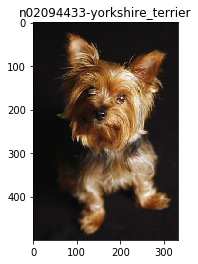

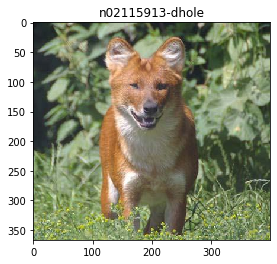

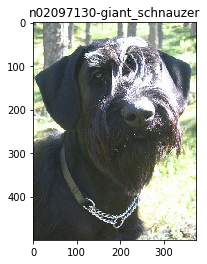

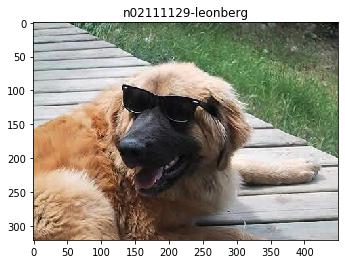

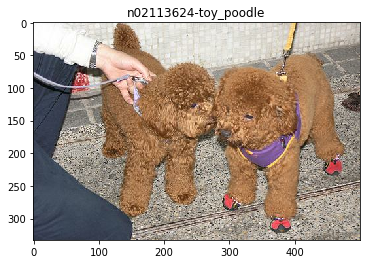

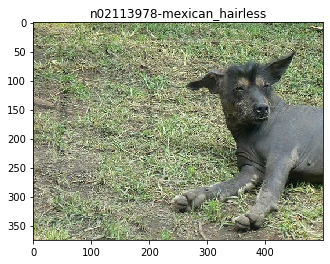

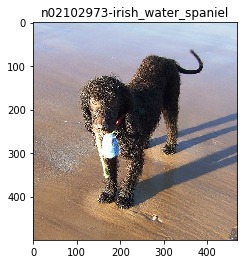

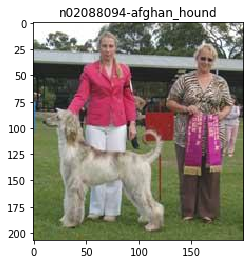

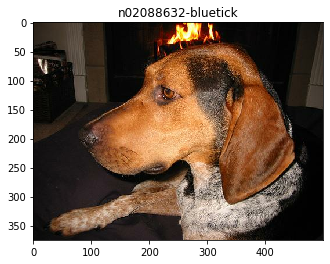

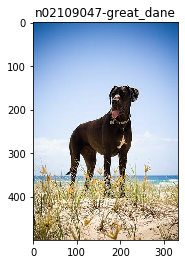

In [ ]:
get_name = info.features['label'].int2str

for doggo in dataset['train'].take(10):
  plt.figure()
  plt.imshow(doggo['image'])
  plt.title(get_name(doggo['label']))

In [ ]:
IMG_LEN = 224
IMG_SHAPE = (IMG_LEN,IMG_LEN,3)
N_BREEDS = 120

training_data = dataset['train']
test_data = dataset['test']

def preprocess(ds_row):
  
  # Image conversion int->float + resizing
  image = tf.image.convert_image_dtype(ds_row['image'], dtype=tf.float32)
  image = tf.image.resize(image, (IMG_LEN, IMG_LEN), method='nearest')
  
  # Onehot encoding labels
  label = tf.one_hot(ds_row['label'],N_BREEDS)

  return image, label

def prepare(dataset, batch_size=None):
  ds = dataset.map(preprocess, num_parallel_calls=4)
  ds = ds.shuffle(buffer_size=1000)
  if batch_size:
    ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

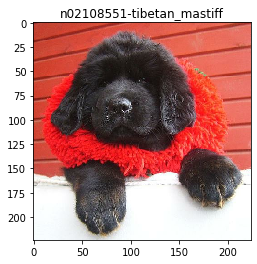

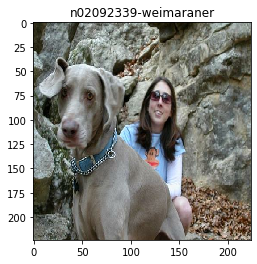

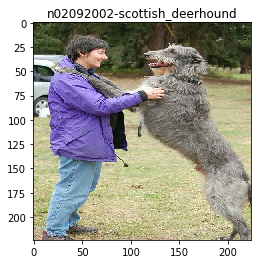

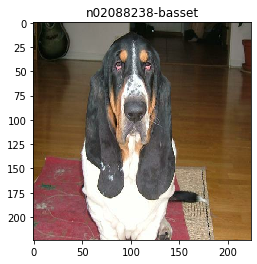

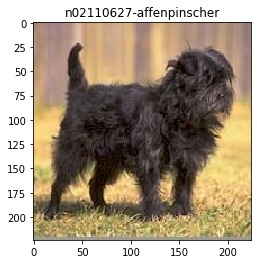

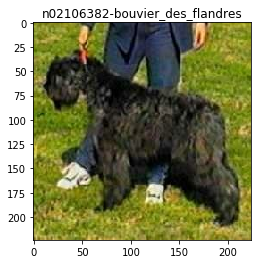

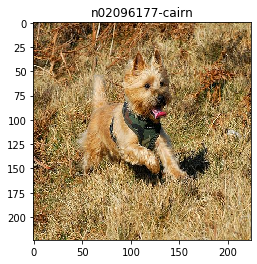

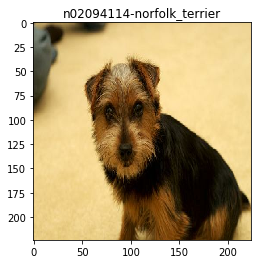

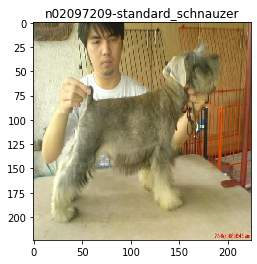

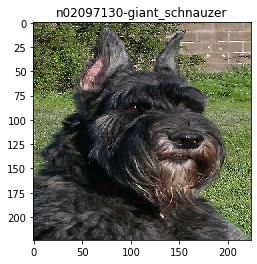

In [ ]:
decode = lambda x: get_name(tf.math.argmax(x))

for pic, label in prepare(training_data).take(10):
  plt.figure()
  plt.imshow(pic)
  plt.title(decode(label))

# Model building + Training

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
base_model.trainable = False

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(N_BREEDS, activation='softmax')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adamax(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               153720    
Total params: 2,411,704
Trainable params: 153,720
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
train_batches = prepare(training_data, batch_size=32)
test_batches = prepare(test_data, batch_size=32)

history = model.fit(train_batches,
                    epochs=30,
                    validation_data=test_batches)


Epoch 1/30
375/375 [==============================] - 53s 141ms/step - loss: 4.7235 - accuracy: 0.0297 - top_k_categorical_accuracy: 0.1152 - val_loss: 4.4542 - val_accuracy: 0.0555 - val_top_k_categorical_accuracy: 0.1812
Epoch 2/30
375/375 [==============================] - 51s 136ms/step - loss: 4.3454 - accuracy: 0.0754 - top_k_categorical_accuracy: 0.2326 - val_loss: 4.1289 - val_accuracy: 0.1080 - val_top_k_categorical_accuracy: 0.3108
Epoch 3/30
375/375 [==============================] - 51s 136ms/step - loss: 4.0542 - accuracy: 0.1353 - top_k_categorical_accuracy: 0.3600 - val_loss: 3.8327 - val_accuracy: 0.1774 - val_top_k_categorical_accuracy: 0.4506
Epoch 4/30
375/375 [==============================] - 51s 135ms/step - loss: 3.8015 - accuracy: 0.1963 - top_k_categorical_accuracy: 0.4792 - val_loss: 3.5625 - val_accuracy: 0.2473 - val_top_k_categorical_accuracy: 0.5601
Epoch 5/30
375/375 [==============================] - 50s 135ms/step - loss: 3.5602 - accuracy: 0.2681 - top

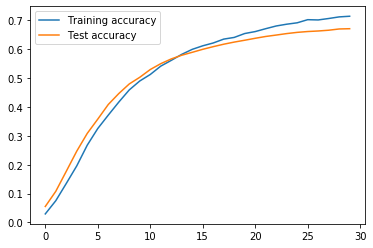

In [ ]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Test accuracy')
plt.legend();

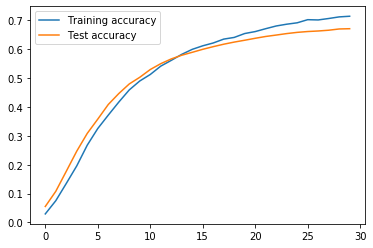

In [ ]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Test accuracy')
plt.legend()
plt.savefig('lc.svg')

# Random doggos from the internet

['n02097298-scotch_terrier', 'n02097130-giant_schnauzer', 'n02105056-groenendael', 'n02096177-cairn', 'n02105251-briard']
['n02109047-great_dane', 'n02087394-rhodesian_ridgeback', 'n02108422-bull_mastiff', 'n02100583-vizsla', 'n02092339-weimaraner']
['n02093428-american_staffordshire_terrier', 'n02100583-vizsla', 'n02099849-chesapeake_bay_retriever', 'n02105412-kelpie', 'n02092339-weimaraner']
['n02093428-american_staffordshire_terrier', 'n02093256-staffordshire_bullterrier', 'n02092339-weimaraner', 'n02096585-boston_bull', 'n02108422-bull_mastiff']
['n02106662-german_shepherd', 'n02105162-malinois', 'n02105412-kelpie', 'n02091467-norwegian_elkhound', 'n02111129-leonberg']
['n02099849-chesapeake_bay_retriever', 'n02105162-malinois', 'n02088466-bloodhound', 'n02093754-border_terrier', 'n02095570-lakeland_terrier']
['n02096294-australian_terrier', 'n02097658-silky_terrier', 'n02094433-yorkshire_terrier', 'n02094114-norfolk_terrier', 'n02094258-norwich_terrier']
['n02088094-afghan_hound',

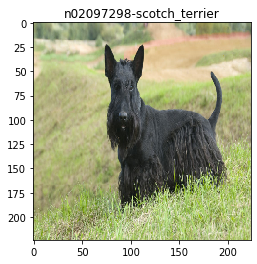

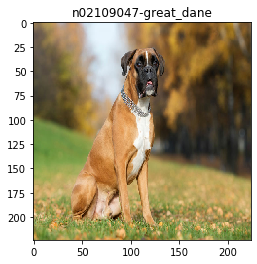

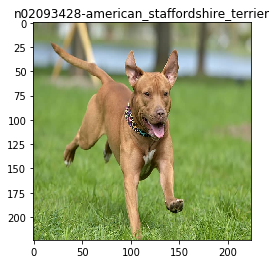

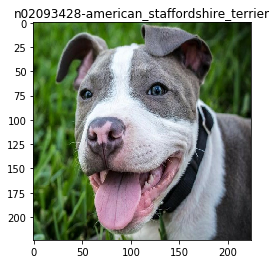

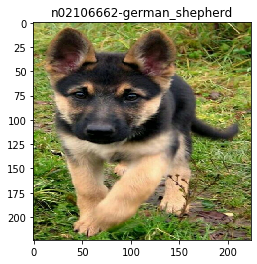

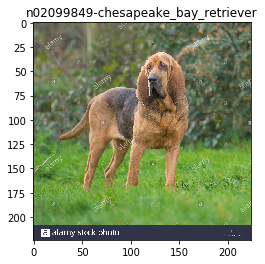

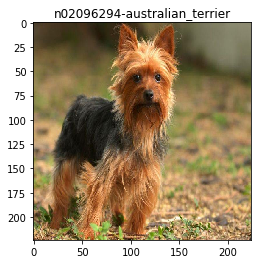

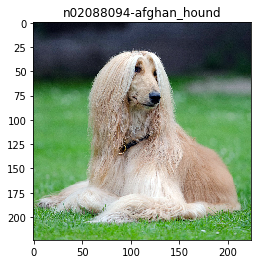

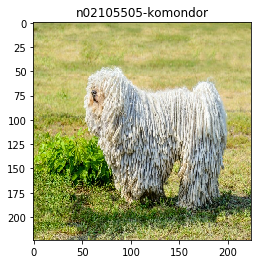

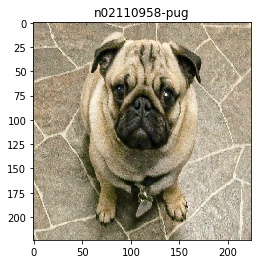

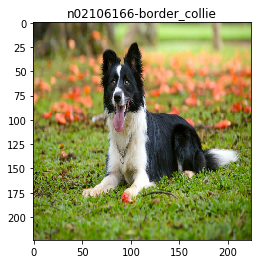

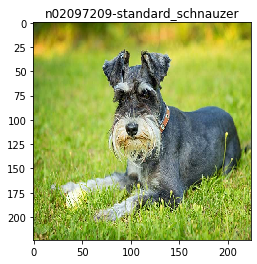

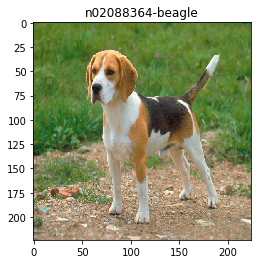

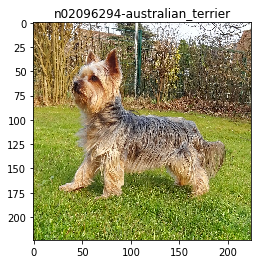

In [ ]:
filename_dataset = tf.data.Dataset.list_files("Doggos/*.jp*g")
image_dataset = filename_dataset.map(lambda x: tf.io.decode_jpeg(tf.io.read_file(x)))

for dog in image_dataset:

  mock_dict = {'image': dog, 'label': 0}
  pic, _ = preprocess(mock_dict)

  plt.figure()
  plt.imshow(pic)

  img_tensor = tf.expand_dims(pic,0)
  pred = model(img_tensor)
  
  top_components = tf.reshape(tf.math.top_k(pred, k=5).indices,shape=[-1])
  top_matches = [get_name(i) for i in top_components]

  plt.title(top_matches[0])
  print(top_matches)

